<a href="https://colab.research.google.com/github/zeynope/hello-world/blob/main/CopyAssignment_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Project by Zeynep Inan (526819)

#Machine learning project: (Un)Masked


This assignment trains a machine learning model that predicts whether an image contains a masked person, unmasked person or incorrectly masked person.

As with any machine learning project, it will compose of five steps:


1. Setting up of the environment
2.   Feature engineering
3.  Building a model
4. Training of the model
5. Evaluation



Since the dataset is a big file, you can download it from [here](https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset). 


##1. Setting the environment


In [ ]:
#Here we import all necessary libraries
import os
import pandas as pd
import numpy as np
import itertools

#RANDOM SEED FOR REPRODDUCABILITY 
np.random.seed(2)

#...Related to tensor flow and Keras.
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers.preprocessing.image_preprocessing import (RandomContrast, RandomRotation,
RandomFlip)
from keras.models import Sequential #To build a model
from keras.layers import (Conv2D, Dropout, MaxPool2D, BatchNormalization, 
Dense, Flatten, Rescaling) #These layers are used to go over the images


#Matplot basics :) These will help us visualise the images in data,
#and also the loss & accuracy metrics.
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', titleweight='bold', titlesize = 10,
    titlepad = 10)
plt.rc('image', cmap = 'magma')

###1.B. Importing the dataset

The image dataset I'm using is downloaded from Kaggle. In order to access the dataset, please upload the provided kaggle.json file into '/content' before running next cell.

In [ ]:
#Kaggle things for the dataset..
!pip install kaggle #Installed the Kaggle API
#There has to be authentication to access these datasets.
#Provided API Token allows access Kaggle datasets. 
from google.colab import files
#Now importing the dataset!
!kaggle datasets download -d shiekhburhan/face-mask-dataset 

print('The dataset is downloaded from Kaggle!')


#The dataset is downloaded as a zip file.
#In order to use the images and labels, we extract the file.

from zipfile import ZipFile
dataset_source = "/content/face-mask-dataset.zip" 
with ZipFile(dataset_source, 'r') as zip:
  zip.extractall()

print('The zip file is extracted.')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
The dataset is downloaded from Kaggle!
The zip file is extracted.


Getting the sets!


In [ ]:
print('This cell will generate training and validation sets from our dataset.')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #In order to avoid future problems...

datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.2) 
ds_train = datagen.flow_from_directory('/content/FMD_DATASET', target_size = (256, 256), batch_size=64,
                                       class_mode = 'categorical', subset = 'training', shuffle = True)

ds_val = datagen.flow_from_directory('/content/FMD_DATASET', target_size = (256, 256), batch_size=64,
                                       class_mode = 'categorical', subset = 'validation', shuffle = False)

print(ds_train.class_indices) #Names of our 3 image classes!
#The labels are inferred from the file names in the directory.


This cell will generate training and validation sets from our dataset.
Found 11630 images belonging to 3 classes.
Found 2906 images belonging to 3 classes.
{'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2}


##2. Feature Engineering

Here we adjust the dataset so that the images are adapted to the model we will use. But first, lets examine our images. 

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


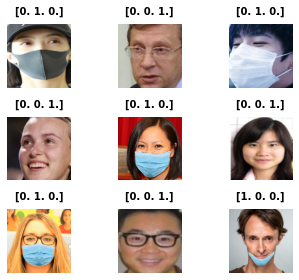

In [ ]:
image_batch, labels_batch = ds_train.next()

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(labels_batch[i])
  plt.axis("off")
#Note:
#[1.0.0.] = 'incorrect_mask
#[0.1.0.] = 'with_mask'
#[0.0.1.] = 'without_mask'

Everything seems normal! Now we can get the shape of the images.

In [ ]:
#Checks what one batch from the training dataset looks like.
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

#This shape is the input shape of the model that will be construccted later.
input_shape = ds_train.image_shape
print(input_shape)

(64, 256, 256, 3)
(64, 3)
(256, 256, 3)


In [ ]:
#OneHotEncoding.
#Appearenly Keras mdoels aren't great with categorical variables ...
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
# define data
data = asarray([['incorrect_mask'], ['with_mask'], ['without_mask']])
print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(data)
print(onehot)




[['incorrect_mask']
 ['with_mask']
 ['without_mask']]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


##3. Building a model!

####Now we are building a Convolutional Neural Network (CNN).


Used [this](https://www.thinkautomation.com/eli5/eli5-what-is-a-convolutional-neural-network/) website for explanations.

In [ ]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.002, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

#This allows the model to keep the best weights and minimizes the chances
#of overfitting.

In [ ]:

from warnings import filters
#We will build a CNN model using Keras layers. 
mask_model = Sequential([
                         

  #Convolution layers extract features from the image.
  #Pooling layers allow detecting  features no matter where they are
    #located on the image.
  
  keras.layers.Conv2D(input_shape = input_shape, filters = 64,  #The input shape is 256x256 pixels with 3 color channels of RGB.
                      kernel_size = 3, activation = 'relu', 
                      padding = 'same'),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(filters = 64, 
                      kernel_size = [3,3], activation = 'relu', 
                      strides = 2, padding = 'same'),
  keras.layers.Dropout(rate= 0.25),
  keras.layers.Conv2D(filters = 128, 
                      kernel_size = [3,3], activation = 'relu', 
                      strides = 1, padding = 'same'),
  keras.layers.MaxPool2D(),
  


  #Classifying head
  keras.layers.Flatten(),
  keras.layers.Dropout(rate= 0.25),
  keras.layers.Dense(units = 6, activation = 'relu'),
  keras.layers.Dense(units = 3, activation= 'softmax') 
])


mask_model.summary()

#COMPILING THE MODEL USING OPTIMIZERS

from keras.optimizer_v2.gradient_descent import SGD
mask_model.compile(optimizer = 'SGD', metrics = ['categorical_accuracy'], loss = 'categorical_crossentropy')
  #SGD - Stochastic Gradient Descent ! 
  #Accuracy of the model is tracked by categorical accuracy
  #The loss metric directs the model to its goal. In this case,
  #Categorical Crossentropy metric ... 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

##4. Training the model

In [ ]:
history = mask_model.fit(ds_train, batch_size = 64, validation_data=ds_val, epochs = 10, verbose = 1, callbacks = early_stopping )

print('done!')

Epoch 1/10
 59/182 [========>.....................] - ETA: 1:31 - loss: 1.0049 - categorical_accuracy: 0.4555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


182/182 [==============================] - 185s 941ms/step - loss: 0.7319 - categorical_accuracy: 0.6377 - val_loss: 0.6452 - val_categorical_accuracy: 0.7223
Epoch 2/10
182/182 [==============================] - 158s 868ms/step - loss: 0.1704 - categorical_accuracy: 0.9463 - val_loss: 0.6580 - val_categorical_accuracy: 0.7622
Epoch 3/10
182/182 [==============================] - 154s 848ms/step - loss: 0.1336 - categorical_accuracy: 0.9594 - val_loss: 0.7107 - val_categorical_accuracy: 0.7488
Epoch 4/10
182/182 [==============================] - 154s 849ms/step - loss: 0.1191 - categorical_accuracy: 0.9628 - val_loss: 0.6980 - val_categorical_accuracy: 0.7653
Epoch 5/10
182/182 [==============================] - 153s 843ms/step - loss: 0.1147 - categorical_accuracy: 0.9631 - val_loss: 0.6750 - val_categorical_accuracy: 0.7719
Epoch 6/10
182/182 [==============================] - 153s 840ms/step - loss: 0.1062 - categorical_accuracy: 0.9669 - val_loss: 0.6947 - val_categorical_accuracy

##5.Evaluating the model

We want to maximize accuracy and minimize loss! We have to see how the model is with validation data; it should be good at classifying  images that it has not seen before. 
This model has an approximate accuracy of 77% after 6 epochs with validation set, which is alright but leaves room for improvement.

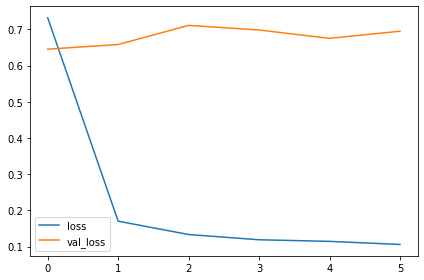

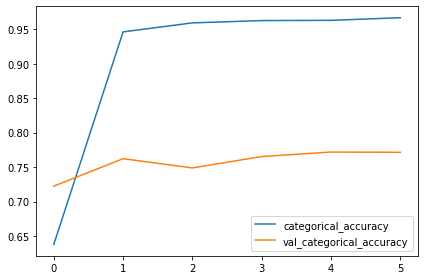

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

The training dataset is fairly small and it includes complex images as well. An improved model can be obtained using a pretained model and fitting it into our training data. 